In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter 
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams["figure.figsize"] = (20,15)

In [3]:
def removestr(x):
    if x != '-nan(ind)':
        return float(x)

In [4]:
df = pd.read_csv('RustlerBluff.txt', sep='\s+')

In [5]:
df.shape

(11027, 6)

In [6]:
df['LLD1'] = df['LLD'].apply(removestr)
df['GR1'] = df['GR'].apply(removestr)

df.dropna(inplace=True)

In [7]:
df.columns

Index(['Depth', 'DT', 'GR', 'LLD', 'NPHI', 'RHOB', 'LLD1', 'GR1'], dtype='object')

In [8]:
df['log10_LLD1'] = np.log10(df['LLD1'])
#df2.head()

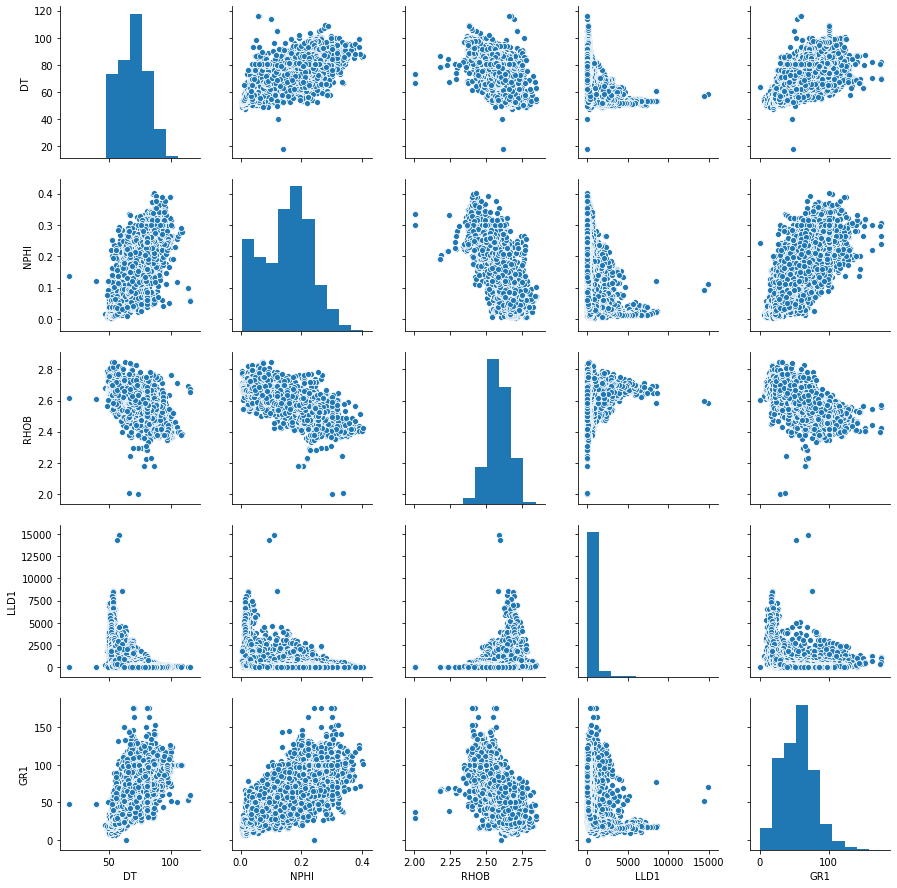

In [9]:
sns.pairplot(df[['DT', 'NPHI', 'RHOB', 'LLD1', 'GR1']])
plt.show()

In [10]:
def litho(x):
    if (x >= 6457.0) & (x < 7411.0):
        return 'BS_LM'
    elif (x >= 7411.0) & (x < 8213.0):
        return 'BS1_SD'
    elif (x >= 8213.0) & (x < 9293.0):
        return 'BS2_SD'
    elif (x >= 9293.0) & (x < 9675.0):
        return 'BS3_SD'
    else:
        return 'Wolfcamp'

In [11]:
def facies_selector(x):
    if ((5 <= x['GR1'] <= 120) and (0.69 <= x['log10_LLD1'] <= 1.4) or (0.02 <= x['NPHI'] <= 0.1)):
        return 'Sh'
    elif ((x['GR1'] >= 120) and (1.41 <= x['log10_LLD1'] <= 2.4) or (0.02 <= x['NPHI'] <= 0.15)):
        return 'OrgSh'
    elif ((48 <= x['GR1'] <= 80) and (0.05 <= x['log10_LLD1'] <= 0.88) or (0.06 <= x['NPHI'] <= 0.25)):
        return 'SS'
    elif ((40 <= x['GR1'] <= 120) and (0.2 <= x['log10_LLD1'] <= 1) and (0.06 <= x['NPHI'] <= 0.4)):
        return 'CSiS'
    elif ((40 <= x['GR1'] <= 120) and (0.2 <= x['log10_LLD1'] <= 0.8) and (0.08 <= x['NPHI'] <= 0.5)):
        return 'FSiS'
    elif ((50 <= x['GR1'] <= 150) and (0.55 <= x['log10_LLD1'] <= 1) and (0.05 <= x['NPHI'] <= 0.15)):
        return 'SiSh'
    elif ((32 <= x['GR1'] <= 85) and (0.46 <= x['log10_LLD1'] <= 1.09) and (0.048 <= x['NPHI'] <= 0.124)):
        return 'MS'
    elif ((19.5 <= x['GR1'] <= 80.45) and (0.47 <= x['log10_LLD1'] <= 1.17) and (0.028 <= x['NPHI'] <= 0.112)):
        return 'WS'
    elif ((20.22 <= x['GR1'] <= 61.5) and (0.21 <= x['log10_LLD1'] <= 0.664) or (0.08 <= x['NPHI'] <= 0.17)):
        return 'D'
    elif ((14 <= x['GR1'] <= 91.4) and (0.21 <= x['log10_LLD1'] <= 1.29) and (0.03 <= x['NPHI'] <= 0.18)):
        return 'PS'
    elif ((15.7 <= x['GR1'] <= 60.8) and (0.11 <= x['log10_LLD1'] <= 1.01) and (0.07 <= x['NPHI'] <= 0.19)):
        return 'BS'
    else:
        return 'Undefined'

In [12]:
df['litho'] = df['Depth'].apply(litho)
df = df.assign(Facies=df.apply(facies_selector, axis=1))

In [13]:
u_facies = df['Facies'].unique()

In [14]:
print(u_facies)

['SS' 'Undefined' 'OrgSh' 'Sh' 'CSiS']


In [15]:
count = Counter(df['litho'])
print (count)

Counter({'Wolfcamp': 4551, 'BS2_SD': 2160, 'BS_LM': 1908, 'BS1_SD': 1604, 'BS3_SD': 764})


In [16]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['litho'])
label_encoded_y = label_encoder.transform(df['litho'])

In [17]:
df['litho_encoded'] = label_encoded_y

In [18]:
classes = list(df['litho'].unique())

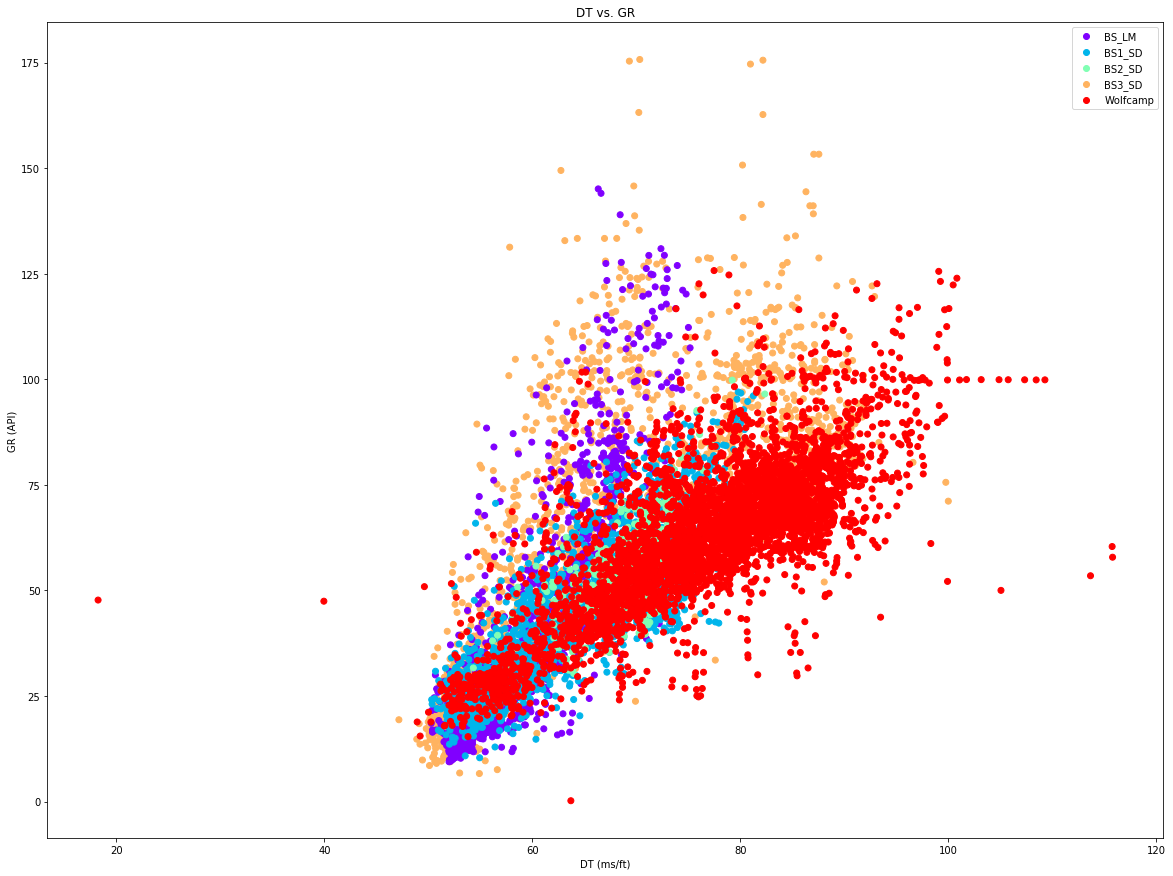

In [19]:
scatter = plt.scatter(df['DT'], df['GR1'], c=df['litho_encoded'], cmap = 'rainbow')
plt.title("DT vs. GR")
plt.xlabel("DT (ms/ft)")
plt.ylabel("GR (API)")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

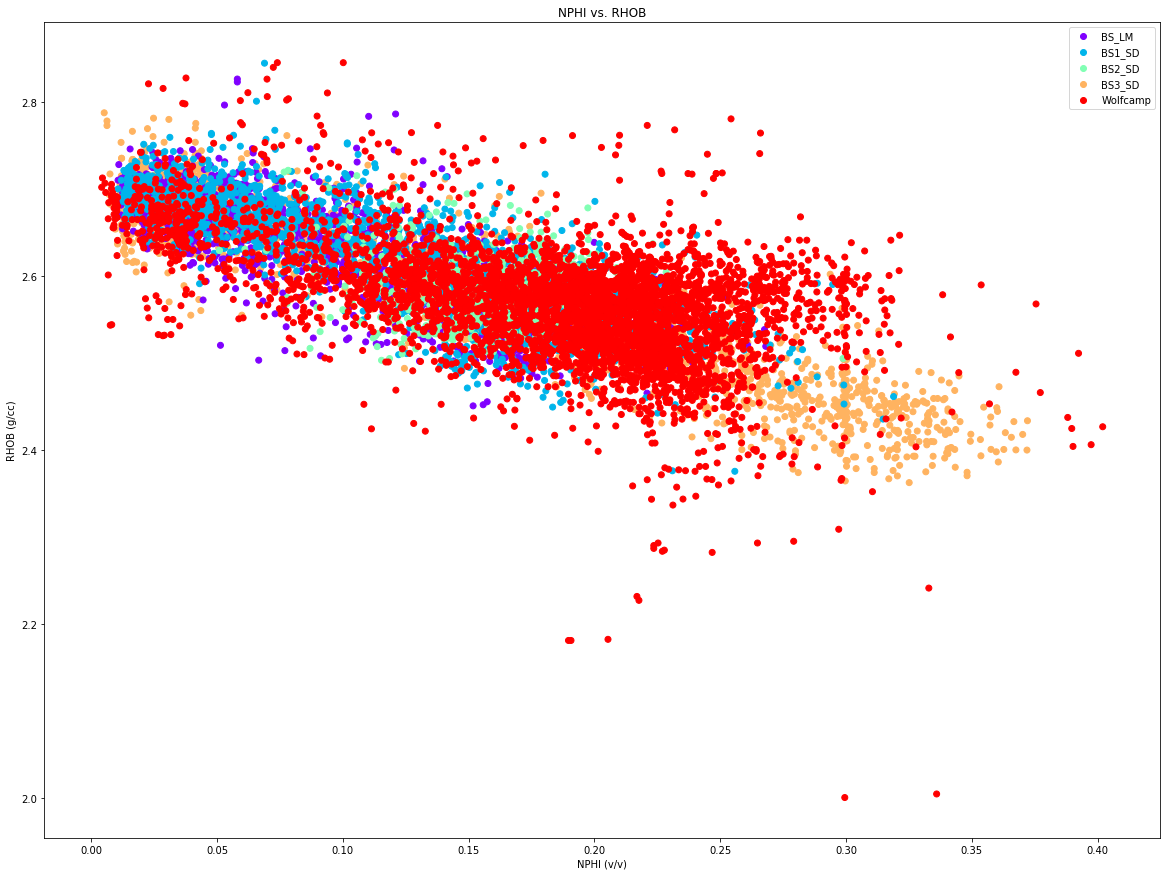

In [20]:
scatter1 = plt.scatter(df['NPHI'], df['RHOB'], c=df['litho_encoded'], cmap = 'rainbow')
plt.title("NPHI vs. RHOB")
plt.xlabel("NPHI (v/v)")
plt.ylabel("RHOB (g/cc)")
plt.legend(handles=scatter1.legend_elements()[0], labels=classes)
plt.show()

# KMeans Clustering

In [21]:
Kmean1 = KMeans(n_clusters=5)
Kmean1.fit(df[['GR1', 'DT']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

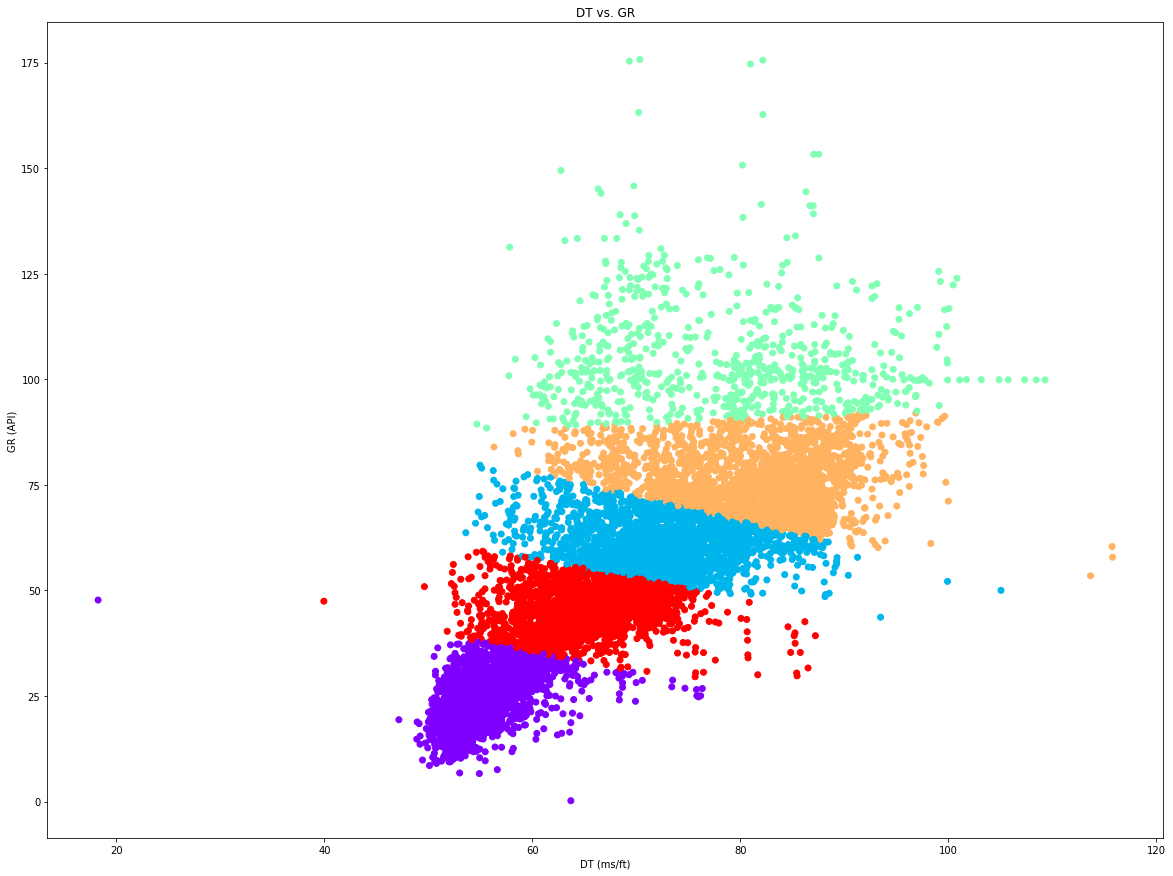

In [22]:
df['gr-dt'] = Kmean1.predict(df[['GR1', 'DT']])
plt.scatter(df['DT'], df['GR1'], c=df['gr-dt'], cmap = 'rainbow')
plt.title("DT vs. GR")
plt.xlabel("DT (ms/ft)")
plt.ylabel("GR (API)")
plt.show()

In [23]:
Kmean2 = KMeans(n_clusters=5)
Kmean2.fit(df[['RHOB', 'NPHI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

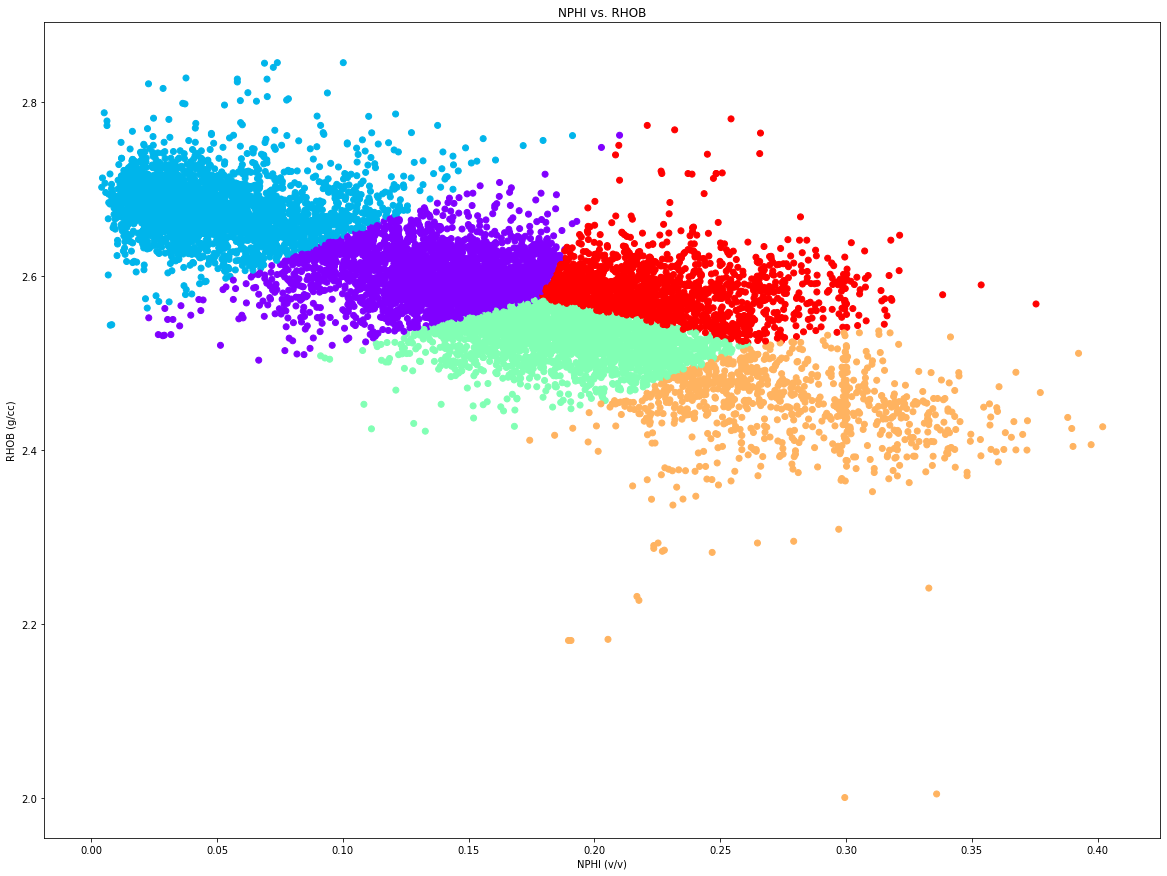

In [24]:
df['rhob-nphi'] = Kmean2.predict(df[['RHOB', 'NPHI']])
plt.scatter(df['NPHI'], df['RHOB'], c=df['rhob-nphi'], cmap = 'rainbow')
plt.title("NPHI vs. RHOB")
plt.xlabel("NPHI (v/v)")
plt.ylabel("RHOB (g/cc)")
plt.show()

# DB Scan   (Results are bad)

In [25]:
dbs1 = DBSCAN(eps=0.9)
df['gr-dt-dbs'] = dbs1.fit_predict(df[['GR1', 'DT']])
#plt.scatter(df['DT'], df['GR1'], c=df['gr-dt-dbs'], cmap = 'rainbow')

In [26]:
dbs2 = DBSCAN()
df['rhob-nphi-dbs'] = dbs2.fit_predict(df[['RHOB', 'NPHI']])
#plt.scatter(df['NPHI'], df['RHOB'], c=df['rhob-nphi-dbs'], cmap = 'rainbow')

# Plotting

In [27]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72']#,'#2E86C1']#, '#AED6F1', '#A569BD', '#196F3D']

In [28]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['litho_encoded'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(9, 12))
    ax[0].plot(logs.GR1, logs.Depth, '-g')
    ax[1].plot(logs.DT, logs.Depth, '-')
    ax[2].plot(logs.LLD1, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.NPHI, logs.Depth, '-', color='r')
    #ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=5)
    im2 = ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=5)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join(['SS' 'Undefined' 'OrgSh' 'Sh' 'CSiS']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR1")
    ax[0].set_xlim(logs.GR1.min(),logs.GR1.max())
    ax[1].set_xlabel("DT")
    ax[1].set_xlim(logs.DT.min(),logs.DT.max())
    ax[2].set_xlabel("LLD1")
    ax[2].set_xlim(logs.LLD1.min(),logs.LLD1.max())
    ax[3].set_xlabel("NPHI")
    ax[3].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    #ax[4].set_xlabel("PE")
    #ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[4].set_xlabel('Facies')
    ax[5].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[4].set_xticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: RustlerBluff', fontsize=14,y=0.94)

# Classification

In [29]:
onehot = pd.get_dummies(df['litho'])
df = df.join(onehot)

In [30]:
#df.drop(['litho'], inplace = True, axis = 1)
#label_encoded_y

In [31]:
df.columns

Index(['Depth', 'DT', 'GR', 'LLD', 'NPHI', 'RHOB', 'LLD1', 'GR1', 'log10_LLD1',
       'litho', 'Facies', 'litho_encoded', 'gr-dt', 'rhob-nphi', 'gr-dt-dbs',
       'rhob-nphi-dbs', 'BS1_SD', 'BS2_SD', 'BS3_SD', 'BS_LM', 'Wolfcamp'],
      dtype='object')

In [32]:
X = df[['DT', 'NPHI', 'RHOB', 'LLD1', 'GR1']]
y = df[['BS1_SD', 'BS2_SD', 'BS3_SD', 'BS_LM', 'Wolfcamp']]

In [33]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
trainx1, testx1, trainy1, testy1 = train_test_split(X, label_encoded_y, test_size=0.2, random_state=42)

# Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators = 150, criterion='entropy')

In [36]:
rf.fit(trainx, trainy)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
pred = rf.predict(testx)

In [38]:
print("Accuracy:", accuracy_score(testy, pred))

Accuracy: 0.8057324840764332


In [39]:
precision, recall, fscore, support = score(testy, pred)

In [40]:
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.85507246 0.85843373 0.88188976 0.94350282 0.93163384]
recall: [0.75159236 0.64189189 0.7        0.85421995 0.90438695]
fscore: [0.8        0.73453608 0.7804878  0.8966443  0.91780822]
support: [314 444 160 391 889]


# XGBoost

In [41]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=5)

In [42]:
xgb.fit(trainx1, trainy1)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_classes=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [43]:
pred1 = xgb.predict(testx1)

In [44]:
print("Accuracy:", accuracy_score(testy1, pred1))

Accuracy: 0.8421292083712466


In [45]:
precision1, recall1, fscore1, support1 = score(testy, pred)

In [46]:
print('precision: {}'.format(precision1))
print('recall: {}'.format(recall1))
print('fscore: {}'.format(fscore1))
print('support: {}'.format(support1))

precision: [0.85507246 0.85843373 0.88188976 0.94350282 0.93163384]
recall: [0.75159236 0.64189189 0.7        0.85421995 0.90438695]
fscore: [0.8        0.73453608 0.7804878  0.8966443  0.91780822]
support: [314 444 160 391 889]


In [47]:
total_pred = xgb.predict(df[['DT', 'NPHI', 'RHOB', 'LLD1', 'GR1']])

In [48]:
df['predicted_values'] = total_pred

In [49]:
df['predicted_actual'] = label_encoder.inverse_transform(df['predicted_values'])

In [50]:
df1 = df[df['LLD1'] < 14000]

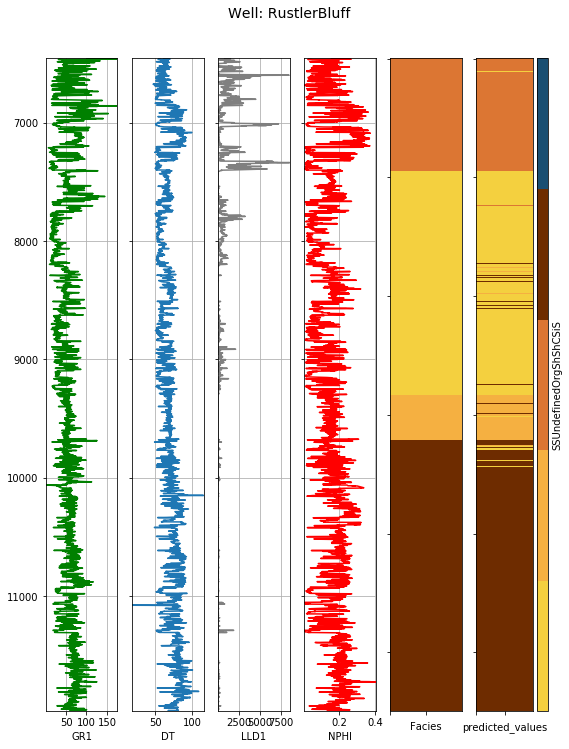

In [51]:
compare_facies_plot(df1, 'predicted_values', facies_colors)